In [54]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os 

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from absl import app
from absl import flags

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import tensorflow_lattice as tfl


In [55]:
# UCI Statlog (Heart) dataset.
csv_file = tf.keras.utils.get_file(
  'heart.csv', 'http://storage.googleapis.com/applied-dl/heart.csv')
training_data_df = pd.read_csv(csv_file).sample(
  frac=1.0, random_state=41).reset_index(drop=True)

# Feature columns.
# 0  age
# 1  sex
# 2  cp        chest pain type (4 values)
# 3  trestbps  resting blood pressure
# 4  chol      serum cholestoral in mg/dl
# 5  fbs       fasting blood sugar > 120 mg/dl
# 6  restecg   resting electrocardiographic results (values 0,1,2)
# 7  thalach   maximum heart rate achieved
# 8  exang     exercise induced angina
# 9  oldpeak   ST depression induced by exercise relative to rest
# 10 slope     the slope of the peak exercise ST segment
# 11 ca        number of major vessels (0-3) colored by flourosopy
# 12 thal      3 = normal; 6 = fixed defect; 7 = reversable defect

# Example slice of training data:
#     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak
# 0   63    1   1       145   233    1        2      150      0      2.3
# 1   67    1   4       160   286    0        2      108      1      1.5
# 2   67    1   4       120   229    0        2      129      1      2.6
# 3   37    1   3       130   250    0        0      187      0      3.5
# 4   41    0   2       130   204    0        2      172      0      1.4
# 5   56    1   2       120   236    0        0      178      0      0.8
# 6   62    0   4       140   268    0        2      160      0      3.6
# 7   57    0   4       120   354    0        0      163      1      0.6
# 8   63    1   4       130   254    0        2      147      0      1.4
# 9   53    1   4       140   203    1        2      155      1      3.1

# Lattice sizes per dimension for Lattice layer.
# Lattice layer expects input[i] to be within [0, lattice_sizes[i] - 1.0], so
# we need to define lattice sizes ahead of calibration layers so we can
# properly specify output range of calibration layers.
lattice_sizes = [3, 2, 2, 2, 2, 2, 2]

# Use ParallelCombination helper layer to group togehter calibration layers
# which have to be executed in paralel in order to be able to use Sequential
# model. Alternatively you can use functional API.
combined_calibrators = tfl.layers.ParallelCombination()


In [56]:
training_data_df.age.describe()

count    303.000000
mean      54.594059
std        9.016370
min       29.000000
25%       48.000000
50%       56.000000
75%       61.000000
max       77.000000
Name: age, dtype: float64

Calibrators

In [57]:
# Configure calibration layers for every feature:

# ############### age ###############

calibrator = tfl.layers.PWLCalibration(
  # Every PWLCalibration layer must have keypoints of piecewise linear
  # function specified. Easiest way to specify them is to uniformly cover
  # entire input range by using numpy.linspace().
  input_keypoints=np.linspace(training_data_df['age'].min(),
                              training_data_df['age'].max(),
                              num=5),
  # You need to ensure that input keypoints have same dtype as layer input.
  # You can do it by setting dtype here or by providing keypoints in such
  # format which will be converted to deisred tf.dtype by default.
  dtype=tf.float32,
  # Output range must correspond to expected lattice input range.
  output_min=0.0,
  output_max=lattice_sizes[0] - 1.0,
  monotonicity='increasing')
combined_calibrators.append(calibrator)

# ############### sex ###############

# For boolean features simply specify CategoricalCalibration layer with 2
# buckets.
calibrator = tfl.layers.CategoricalCalibration(
  num_buckets=2,
  output_min=0.0,
  output_max=lattice_sizes[1] - 1.0,
  # Initializes all outputs to (output_min + output_max) / 2.0.
  kernel_initializer='constant')
combined_calibrators.append(calibrator)

# ############### cp ###############

calibrator = tfl.layers.PWLCalibration(
  # Here instead of specifying dtype of layer we convert keypoints into
  # np.float32.
  input_keypoints=np.linspace(1, 4, num=4, dtype=np.float32),
  output_min=0.0,
  output_max=lattice_sizes[2] - 1.0,
  monotonicity='increasing',
  # You can specify TFL regularizers as tuple ('regularizer name', l1, l2).
  kernel_regularizer=('hessian', 0.0, 1e-4))
combined_calibrators.append(calibrator)

# ############### trestbps ###############

calibrator = tfl.layers.PWLCalibration(
  # Alternatively to uniform keypoints you might want to use quantiles as
  # keypoints.
  input_keypoints=np.quantile(
      training_data_df['trestbps'], np.linspace(0.0, 1.0, num=5)),
  dtype=tf.float32,
  # Together with quantile keypoints you might want to initialize piecewise
  # linear function to have 'equal_slopes' in order for output of layer
  # after initialization to preserve original distribution.
  kernel_initializer='equal_slopes',
  output_min=0.0,
  output_max=lattice_sizes[3] - 1.0,
  # You might consider clamping extreme inputs of the calibrator to output
  # bounds.
  clamp_min=True,
  clamp_max=True,
  monotonicity='increasing')
combined_calibrators.append(calibrator)

# ############### chol ###############

calibrator = tfl.layers.PWLCalibration(
  # Explicit input keypoint initialization.
  input_keypoints=[126.0, 210.0, 247.0, 286.0, 564.0],
  dtype=tf.float32,
  output_min=0.0,
  output_max=lattice_sizes[4] - 1.0,
  # Monotonicity of calibrator can be 'decreasing'. Note that corresponding
  # lattice dimension must have 'increasing' monotonicity regardless of
  # monotonicity direction of calibrator.
  # Its not some weird configuration hack. Its just how math works :)
  monotonicity='decreasing',
  # Convexity together with decreasing monotonicity result in diminishing
  # return constraint.
  convexity='convex',
  # You can specify list of regularizers. You are not limited to TFL
  # regularizrs. Feel free to use any :)
  kernel_regularizer=[('laplacian', 0.0, 1e-4),
                      keras.regularizers.l1_l2(l1=0.001)])
combined_calibrators.append(calibrator)

# ############### fbs ###############

calibrator = tfl.layers.CategoricalCalibration(
  num_buckets=2,
  output_min=0.0,
  output_max=lattice_sizes[5] - 1.0,
  # For categorical calibration layer monotonicity is specified for pairs
  # of indices of categories. Output for first category in pair will be
  # smaller than output for second category.
  #
  # Don't forget to set monotonicity of corresponding dimension of Lattice
  # layer to 'increasing'.
  monotonicities=[(0, 1)],
  # This initializer is identical to default one('uniform'), but has fixed
  # seed in order to simplify experimentation.
  kernel_initializer=keras.initializers.RandomUniform(
      minval=0.0, maxval=lattice_sizes[5] - 1.0, seed=1))
combined_calibrators.append(calibrator)

# ############### restecg ###############

calibrator = tfl.layers.CategoricalCalibration(
  num_buckets=3,
  output_min=0.0,
  output_max=lattice_sizes[6] - 1.0,
  # Categorical monotonicity can be partial order.
  monotonicities=[(0, 1), (0, 2)],
  # Categorical calibration layer supports standard Keras regularizers.
  kernel_regularizer=keras.regularizers.l1_l2(l1=0.001),
  kernel_initializer='constant')
combined_calibrators.append(calibrator)

# Create Lattice layer to nonlineary fuse output of calibrators. Don't forget
# to specify monotonicity 'increasing' for any dimension which calibrator is
# monotonic regardless of monotonicity direction of calibrator. This includes
# partial monotonicity of CategoricalCalibration layer.
lattice = tfl.layers.Lattice(
  lattice_sizes=lattice_sizes,
  monotonicities=['increasing', 'none', 'increasing', 'increasing',
                  'increasing', 'increasing', 'increasing'],
  output_min=0.0,
  output_max=1.0)

In [58]:
combined_calibrators

In [59]:
model = keras.models.Sequential()
# We have just 2 layer as far as Sequential model is concerned.
# PWLConcatenate layer takes care of grouping calibrators.
model.add(combined_calibrators)
model.add(lattice)
model.compile(loss=keras.losses.mean_squared_error,
            optimizer=keras.optimizers.Adagrad(learning_rate=1.0), metrics=[tf.keras.metrics.Accuracy()])

In [60]:
features = training_data_df[
  ['age', 'sex', 'cp',
   'trestbps', 'chol', 'fbs', 'restecg']].values.astype(np.float32)
target = training_data_df[['target']].values.astype(np.float32)

# model.fit(features,
#         target,
#         batch_size=32,
#         epochs=200,
#         validation_split=0.2,
#         shuffle=False)


My lattice

In [61]:
lattice_sizes = [10, 10]
lattice = tfl.layers.Lattice(
    # Number of vertices along each dimension.
    units=2,
    lattice_sizes=lattice_sizes,
    # You can specify monotonicity constraints.
    monotonicities=['increasing', 'increasing'],
    output_min=0.0,
    output_max=100)

In [62]:
calibrator_w = tfl.layers.PWLCalibration(
  # Every PWLCalibration layer must have keypoints of piecewise linear
  # function specified. Easiest way to specify them is to uniformly cover
  # entire input range by using numpy.linspace().
  input_keypoints=np.linspace(0, 100,num=100),
  units=1,
  # You need to ensure that input keypoints have same dtype as layer input.
  # You can do it by setting dtype here or by providing keypoints in such
  # format which will be converted to deisred tf.dtype by default.
  dtype=tf.float32,
  # Output range must correspond to expected lattice input range.
  output_min=0.0,
  output_max=lattice_sizes[0] - 1.0,
  monotonicity='increasing')

calibrator_l = tfl.layers.PWLCalibration(
  # Every PWLCalibration layer must have keypoints of piecewise linear
  # function specified. Easiest way to specify them is to uniformly cover
  # entire input range by using numpy.linspace().
  input_keypoints=np.linspace(0, 20,num=100),
  units=1,
  # You need to ensure that input keypoints have same dtype as layer input.
  # You can do it by setting dtype here or by providing keypoints in such
  # format which will be converted to deisred tf.dtype by default.
  dtype=tf.float32,
  # Output range must correspond to expected lattice input range.
  output_min=0.0,
  output_max=lattice_sizes[1] - 1.0,
  monotonicity='increasing')

combined_calibrators = combined_calibrators = tfl.layers.ParallelCombination([calibrator_w, calibrator_l], single_output=True)

In [10]:
obs = np.array([2.,100.])
lattice.compute_output_shape(obs[None,:])

array([], shape=(0, 2), dtype=float64)

In [12]:
model = keras.models.Sequential()
# We have just 2 layer as far as Sequential model is concerned.
# PWLConcatenate layer takes care of grouping calibrators.
model.add(combined_calibrators)
model.add(tf.keras.layers.RepeatVector(2))
model.add(lattice)
model.compile(loss=keras.losses.mean_squared_error,
            optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [13]:
x = tf.ones((1, 2))
y = model(x)
y

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[3.0000005, 3.0000005]], dtype=float32)>

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
parallel_combination_1 (Para multiple                  200       
_________________________________________________________________
repeat_vector_1 (RepeatVecto multiple                  0         
_________________________________________________________________
lattice_1 (Lattice)          multiple                  200       
Total params: 400
Trainable params: 400
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.predict(obs[None,])

array([[50.99997, 50.99997]], dtype=float32)

In [16]:
weights = model.weights[0]

In [17]:
model.save('h.h5')

## Learning aav using lattice

In [18]:
from dcc import AAV, Parameters
import numpy as np
import matplotlib.pyplot as plt

p = Parameters()
aav= AAV(p)
ws = np.linspace(0, 200, 100)
ls = np.linspace(0, 5, 100)
ww, ll = np.meshgrid(ws, ls)
z = np.zeros_like(ww)
features = []
for i, wx in enumerate(ws):
    for j, ly in enumerate(ls):
        z[j, i] = -aav.u(ly, wx)
        features.append([ly,wx, -z[j, i]])

[INFO] [2020-07-05 13:48:11,459] [AAV] - Instantiated @ AAV


Text(0.5, 1.0, 'Simplest default with labels')

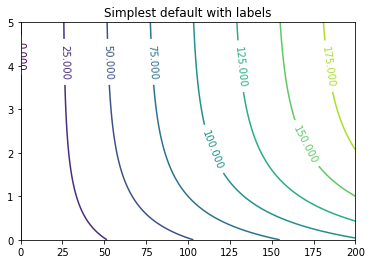

In [19]:
fig, ax = plt.subplots()
CS = ax.contour(ww, ll, z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Simplest default with labels')

In [20]:
dataset = pd.DataFrame(features, columns=['l', 'w', 'target'])

In [21]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
train_labels = train_dataset.target.copy()
test_labels = test_dataset.target.copy()
train_dataset = train_dataset.drop(labels=['target'], axis=1)
test_dataset = test_dataset.drop(labels=['target'], axis=1)

In [22]:
import seaborn as sns

Neural net:

In [23]:
nn = tf.keras.models.Sequential()
nn.add(tf.keras.layers.Dense(32, activation='relu'))
nn.add(tf.keras.layers.Dense(32, activation='relu'))
nn.add(tf.keras.layers.Dense(1, activation='linear'))
nn.compile(loss=tf.keras.losses.mean_squared_error, optimizer='adam')

In [24]:
nn.build(input_shape=(1,2))

In [25]:
nn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  96        
_________________________________________________________________
dense_1 (Dense)              multiple                  1056      
_________________________________________________________________
dense_2 (Dense)              multiple                  33        
Total params: 1,185
Trainable params: 1,185
Non-trainable params: 0
_________________________________________________________________


In [26]:
example_batch = train_dataset[:10].to_numpy()
example_result = nn.predict(example_batch)
example_result

array([[-27.151707 ],
       [ -2.5588174],
       [ -6.58401  ],
       [-17.341606 ],
       [ -6.672092 ],
       [-24.065762 ],
       [-16.165024 ],
       [-18.714733 ],
       [ -7.4959717],
       [ -9.790575 ]], dtype=float32)

In [31]:
EPOCHS = 100

history = nn.fit(train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=False)

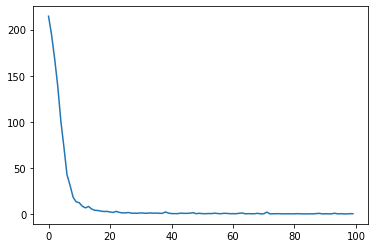

In [32]:
plt.plot(history.history['val_loss'])

In [33]:
nn_pred = np.zeros_like(ww)
for i, wx in enumerate(ws):
    for j, ly in enumerate(ls):
        obs = np.array([ly, wx])
        nn_pred[j, i] = nn.predict_on_batch(obs[None,:])

Text(0.5, 1.0, 'Simplest default with labels')

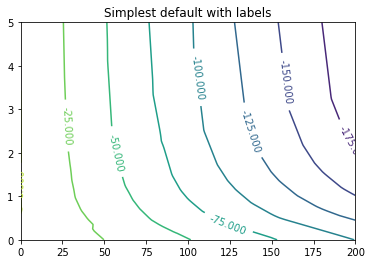

In [34]:
fig, ax = plt.subplots()
CS = ax.contour(ww, ll, nn_pred)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Simplest default with labels')

In [35]:
np.sum(np.power(nn.predict_on_batch(test_dataset.to_numpy()).numpy().flatten() - test_labels, 2))

718.6511415575551

## Regression with lattices

In [53]:
lattice_sizes = [2, 2]
lattice_sizes2 = [2, 2, 2]
lattice_sizes3 = [2, 2]
lattice1 = tfl.layers.Lattice(
    # Number of vertices along each dimension.
    units=3,
    lattice_sizes=lattice_sizes,
    # You can specify monotonicity constraints.
    monotonicities=['increasing', 'increasing'])

lattice2 = tfl.layers.Lattice(
    units=2,
    lattice_sizes=lattice_sizes2,
    # You can specify monotonicity constraints.
    monotonicities=['increasing', 'increasing', 'increasing'])

lattice3 = tfl.layers.Lattice(
    units=1,
    lattice_sizes=lattice_sizes3,
    # You can specify monotonicity constraints.
    monotonicities=['increasing', 'increasing'], output_min=0, output_max=200)

In [37]:
calibrator_w = tfl.layers.PWLCalibration(
  # Every PWLCalibration layer must have keypoints of piecewise linear
  # function specified. Easiest way to specify them is to uniformly cover
  # entire input range by using numpy.linspace().
  input_keypoints=np.linspace(0, 200,num=100),
  units=1,
  # You need to ensure that input keypoints have same dtype as layer input.
  # You can do it by setting dtype here or by providing keypoints in such
  # format which will be converted to deisred tf.dtype by default.
  dtype=tf.float32,
  # Output range must correspond to expected lattice input range.
  output_min=0.0,
  output_max=lattice_sizes[0] - 1.0,
  monotonicity='increasing')

calibrator_l = tfl.layers.PWLCalibration(
  # Every PWLCalibration layer must have keypoints of piecewise linear
  # function specified. Easiest way to specify them is to uniformly cover
  # entire input range by using numpy.linspace().
  input_keypoints=np.linspace(0, 20,num=100),
  units=1,
  # You need to ensure that input keypoints have same dtype as layer input.
  # You can do it by setting dtype here or by providing keypoints in such
  # format which will be converted to deisred tf.dtype by default.
  dtype=tf.float32,
  # Output range must correspond to expected lattice input range.
  output_min=0.0,
  output_max=lattice_sizes[1] - 1.0,
  monotonicity='increasing')

combined_calibrators1 = combined_calibrators = tfl.layers.ParallelCombination([calibrator_w, calibrator_l], single_output=True)

In [38]:
model = keras.models.Sequential()
# We have just 2 layer as far as Sequential model is concerned.
# PWLConcatenate layer takes care of grouping calibrators.
model.add(combined_calibrators1)
model.add(tf.keras.layers.RepeatVector(3))
model.add(lattice1)
model.compile(loss=keras.losses.mean_squared_error,
            optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [39]:
x = tf.ones((1, 2))
y = model(x)
y

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.0275, 0.0275, 0.0275]], dtype=float32)>

In [40]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
parallel_combination_2 (Para multiple                  200       
_________________________________________________________________
repeat_vector_2 (RepeatVecto multiple                  0         
_________________________________________________________________
lattice_2 (Lattice)          multiple                  1200      
Total params: 1,400
Trainable params: 1,400
Non-trainable params: 0
_________________________________________________________________


In [41]:
calibratorw2 = tfl.layers.PWLCalibration(
  # Every PWLCalibration layer must have keypoints of piecewise linear
  # function specified. Easiest way to specify them is to uniformly cover
  # entire input range by using numpy.linspace().
  input_keypoints=np.linspace(0, 20,num=100),
  units=3,
  # You need to ensure that input keypoints have same dtype as layer input.
  # You can do it by setting dtype here or by providing keypoints in such
  # format which will be converted to deisred tf.dtype by default.
  dtype=tf.float32,
  # Output range must correspond to expected lattice input range.
  output_min=0.0,
  output_max=lattice_sizes2[0] - 1.0,
  monotonicity='increasing')

calibratorw3 = tfl.layers.PWLCalibration(
  # Every PWLCalibration layer must have keypoints of piecewise linear
  # function specified. Easiest way to specify them is to uniformly cover
  # entire input range by using numpy.linspace().
  input_keypoints=np.linspace(0, 20,num=100),
  units=2,
  # You need to ensure that input keypoints have same dtype as layer input.
  # You can do it by setting dtype here or by providing keypoints in such
  # format which will be converted to deisred tf.dtype by default.
  dtype=tf.float32,
  # Output range must correspond to expected lattice input range.
  output_min=0.0,
  output_max=lattice_sizes3[0] - 1.0,
  monotonicity='increasing')

In [42]:
model = keras.models.Sequential()
# We have just 2 layer as far as Sequential model is concerned.
# PWLConcatenate layer takes care of grouping calibrators.
model.add(combined_calibrators1)
model.add(tf.keras.layers.RepeatVector(3))
model.add(lattice1)
model.add(calibratorw2)
model.add(tf.keras.layers.RepeatVector(2))
model.add(lattice2)
model.add(calibratorw3)
model.add(lattice3)
model.compile(loss=keras.losses.mean_squared_error,
            optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [43]:
x = tf.ones((1, 2))
y = model(x)
y

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00687492]], dtype=float32)>

In [44]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
parallel_combination_2 (Para multiple                  200       
_________________________________________________________________
repeat_vector_3 (RepeatVecto multiple                  0         
_________________________________________________________________
lattice_2 (Lattice)          multiple                  1200      
_________________________________________________________________
pwl_calibration_8 (PWLCalibr multiple                  300       
_________________________________________________________________
repeat_vector_4 (RepeatVecto multiple                  0         
_________________________________________________________________
lattice_3 (Lattice)          multiple                  16000     
_________________________________________________________________
pwl_calibration_9 (PWLCalibr multiple                 

In [45]:
model.fit(train_dataset.to_numpy(), -train_labels.to_numpy(), epochs=100,validation_split=0.2, shuffle=False)

Train on 6400 samples, validate on 1600 samples
Epoch 1/100
6400/6400 [==============================] - 7s 1ms/sample - loss: 9739.8751 - val_loss: 9118.8086
Epoch 2/100
6400/6400 [==============================] - 3s 426us/sample - loss: 9232.5242 - val_loss: 8628.9618
Epoch 3/100
6400/6400 [==============================] - 3s 419us/sample - loss: 8812.2324 - val_loss: 8275.8331
Epoch 4/100
6400/6400 [==============================] - 3s 420us/sample - loss: 8407.7253 - val_loss: 7842.4663
Epoch 5/100
6400/6400 [==============================] - 3s 416us/sample - loss: 8020.8262 - val_loss: 7583.5225
Epoch 6/100
6400/6400 [==============================] - 3s 423us/sample - loss: 7737.7346 - val_loss: 7226.9945
Epoch 7/100
6400/6400 [==============================] - 3s 425us/sample - loss: 7326.7924 - val_loss: 6908.3119
Epoch 8/100
6400/6400 [==============================] - 3s 430us/sample - loss: 7116.8463 - val_loss: 6707.0381
Epoch 9/100
6400/6400 [===========================

In [46]:
lattice_pred = np.zeros_like(ww)
for i, wx in enumerate(ws):
    for j, ly in enumerate(ls):
        obs = np.array([ly, wx])
        lattice_pred[j, i] = model.predict_on_batch(obs[None,:])

In [47]:
lattice_pred

array([[18.07493973, 18.07493973, 18.07493973, ..., 54.4478569 ,
        54.4478569 , 54.4478569 ],
       [18.07493973, 18.07493973, 18.07493973, ..., 55.91042328,
        55.91042328, 55.91042328],
       [18.07493973, 18.07493973, 18.07493973, ..., 56.94372177,
        56.94372177, 56.94372177],
       ...,
       [18.07493973, 18.07493973, 18.07493973, ..., 99.96323395,
        99.96323395, 99.96323395],
       [18.07493973, 18.07493973, 18.07493973, ..., 99.96323395,
        99.96323395, 99.96323395],
       [18.07493973, 18.07493973, 18.07493973, ..., 99.96323395,
        99.96323395, 99.96323395]])

Text(0.5, 1.0, 'Simplest default with labels')

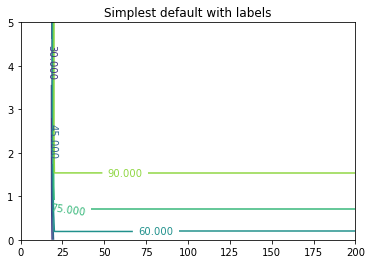

In [48]:
fig, ax = plt.subplots()
CS = ax.contour(ww, ll, lattice_pred)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Simplest default with labels')

Text(0.5, 1.0, 'Simplest default with labels')

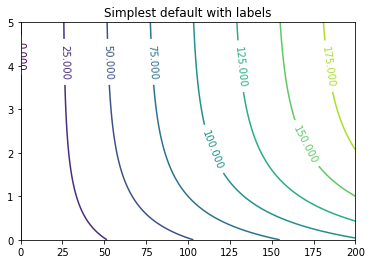

In [49]:
fig, ax = plt.subplots()
CS = ax.contour(ww, ll, z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Simplest default with labels')

In [50]:
lattice_pred = model.predict_on_batch(test_dataset.to_numpy())

In [51]:
model.predict_on_batch(np.array([2,200])[None,:])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[94.014465]], dtype=float32)>

In [52]:
yhat.numpy().flatten() - test_labels

NameError: name 'yhat' is not defined

In [ ]:
test_labels

In [ ]:
plt.plot(lattice_pred.numpy().flatten())